In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import root_mean_squared_error

In [2]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='file:///d:/rebeka/developer/courses/machine-learning-ops-zoomcamp/code/2_mlflow/mlruns/1', creation_time=1714578727670, experiment_id='1', last_update_time=1714578727670, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
df = pd.read_parquet("data/green_tripdata_2021-01.parquet")

df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

df[categorical] = df[categorical].astype(str)

In [4]:
train_dicts = df[categorical + numerical].to_dict(orient="records")

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = "duration"
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(
    y_train,
    y_pred,
)

9.838799799829623

C:\Users\rebek\AppData\Local\Temp\ipykernel_80956\1219225857.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label="prediction")
C:\Users\rebek\AppData\Local\Temp\ipykernel_80956\1219225857.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label="actual")


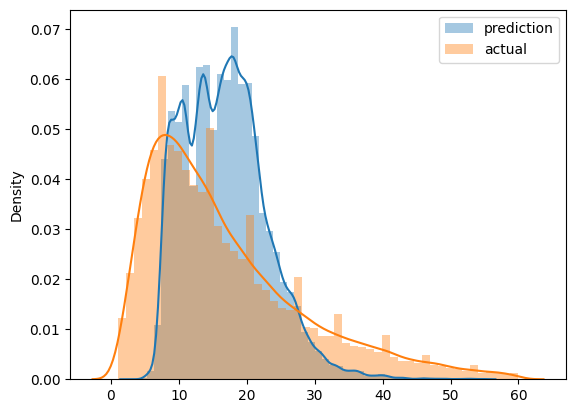

In [5]:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_train, label="actual")

plt.legend()

In [6]:
def read_dataframe(filename):
    if filename.endswith(".csv"):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith(".parquet"):
        df = pd.read_parquet(filename)

    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)

    return df

In [7]:
df_train = read_dataframe("./data/green_tripdata_2021-01.parquet")
df_val = read_dataframe("./data/green_tripdata_2021-02.parquet")

len(df_train), len(df_val)

(73908, 61921)

In [8]:
df_train["PU_DO"] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]

In [9]:
categorical = ["PU_DO"]  #'PULocationID', 'DOLocationID'
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [10]:
target = "duration"
y_train = df_train[target].values
y_val = df_val[target].values

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.75871521021275

In [12]:
with open("models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)

In [13]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

11.167275941179728

In [14]:
with mlflow.start_run():

    mlflow.set_tag("developer", "cristian")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

In [15]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)


def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50,
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {"loss": rmse, "status": STATUS_OK}


search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", -3, 0),
    "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
    "reg_lambda": hp.loguniform("reg_lambda", -6, -1),
    "min_child_weight": hp.loguniform("min_child_weight", -1, 3),
    "objective": "reg:linear",
    "seed": 42,
}

best_result = fmin(
    fn=objective, space=search_space, algo=tpe.suggest, max_evals=50, trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\Users\rebek\.virtualenvs\machine-learning-ops-zoomcamp-yuDfY6b0\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:08:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.88707                          
[1]	validation-rmse:9.85812                           
[2]	validation-rmse:9.07056                           
[3]	validation-rmse:8.47467                           
[4]	validation-rmse:8.02879                           
[5]	validation-rmse:7.69834                           
[6]	validation-rmse:7.45324                           
[7]	validation-rmse:7.27222                           
[8]	validation-rmse:7.13873                           
[9]	validation-rmse:7.04000                           
[10]	validation-rmse:6.96672                          
[11]	validation-rmse:6.91002                          
[12]	validation-rmse:6.86612                          
[13]	validation-rmse:6.83254                          
[14]	validation-rmse:6.80508                          
[15]	validation-rmse:6.78331                          
[16]	validation-rmse:6.76535                          
[17]	validation-rmse:6.75216                          
[18]	valid

c:\Users\rebek\.virtualenvs\machine-learning-ops-zoomcamp-yuDfY6b0\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:11:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.98103                                                       
[1]	validation-rmse:7.55400                                                       
[2]	validation-rmse:6.97118                                                       
[3]	validation-rmse:6.72734                                                       
[4]	validation-rmse:6.62074                                                       
[5]	validation-rmse:6.57094                                                       
[6]	validation-rmse:6.54068                                                       
[7]	validation-rmse:6.52129                                                       
[8]	validation-rmse:6.50813                                                       
[9]	validation-rmse:6.50013                                                       
[10]	validation-rmse:6.49757                                                      
[11]	validation-rmse:6.49323                                                      
[12]

c:\Users\rebek\.virtualenvs\machine-learning-ops-zoomcamp-yuDfY6b0\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:11:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.71897                                                     
  4%|▍         | 2/50 [03:07<1:14:53, 93.61s/trial, best loss: 6.360617790538846]


KeyboardInterrupt: 

In [16]:
params = {
    "learning_rate": 0.09585355369315604,
    "max_depth": 30,
    "min_child_weight": 1.060597050922164,
    "objective": "reg:linear",
    "reg_alpha": 0.018060244040060163,
    "reg_lambda": 0.011658731377413597,
    "seed": 42,
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, "validation")],
    early_stopping_rounds=50,
)

2024/05/10 11:27:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0eca066b005c4a8ab746cdb38a53a3ff', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
c:\Users\rebek\.virtualenvs\machine-learning-ops-zoomcamp-yuDfY6b0\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:28:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.44482
[1]	validation-rmse:10.77202
[2]	validation-rmse:10.18363
[3]	validation-rmse:9.67396
[4]	validation-rmse:9.23166
[5]	validation-rmse:8.84808
[6]	validation-rmse:8.51883
[7]	validation-rmse:8.23597
[8]	validation-rmse:7.99320
[9]	validation-rmse:7.78709
[10]	validation-rmse:7.61022
[11]	validation-rmse:7.45952
[12]	validation-rmse:7.33049
[13]	validation-rmse:7.22098
[14]	validation-rmse:7.12713
[15]	validation-rmse:7.04752
[16]	validation-rmse:6.98005
[17]	validation-rmse:6.92232
[18]	validation-rmse:6.87112
[19]	validation-rmse:6.82740
[20]	validation-rmse:6.78995
[21]	validation-rmse:6.75792
[22]	validation-rmse:6.72994
[23]	validation-rmse:6.70547
[24]	validation-rmse:6.68390
[25]	validation-rmse:6.66421
[26]	validation-rmse:6.64806
[27]	validation-rmse:6.63280
[28]	validation-rmse:6.61924
[29]	validation-rmse:6.60773
[30]	validation-rmse:6.59777
[31]	validation-rmse:6.58875
[32]	validation-rmse:6.58107
[33]	validation-rmse:6.57217
[34]	validation-rmse:

2024/05/10 11:30:27 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/10 11:30:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\rebek\.virtualenvs\machine-learning-ops-zoomcamp-yuDfY6b0\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:30:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."


In [ ]:
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
)
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
    LinearSVR,
):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)